In [4]:
import csv
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.preprocessing import LabelEncoder, Imputer
from sklearn.metrics import auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint as sp_randint
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
import random
import numpy as np


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
os.chdir("/home/thibault/Documents/oilprediction_challenge/Code/functions")
import skmice
import functions as fn

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

pd.set_option("display.max_columns", 200)

PATH = "/home/thibault/Documents/oilprediction_challenge/"
PATH_DATA = PATH + "Data/"
PATH_RESULT = PATH + "Result/"

In [5]:
random.seed(42)

# 1 - LOAD DATA

In [6]:
Y = pd.read_csv(PATH_DATA + "Y_train.csv", sep=";")
X = pd.read_csv(PATH_DATA + "Train.csv", sep=";")
final_test = pd.read_csv(PATH_DATA + "Test.csv", sep=";")

X_full = pd.concat([X, final_test])

# 2 - Data transformation

### First analysis

In [7]:
NUMERIC_VARIABLE = [x for x in X.columns if x not in ["ID", "month", "country"]]

X.loc[:, NUMERIC_VARIABLE].describe()

,1_diffClosing stocks(kmt),1_diffExports(kmt),1_diffImports(kmt),1_diffRefinery intake(kmt),1_diffWTI,1_diffSumClosing stocks(kmt),1_diffSumExports(kmt),1_diffSumImports(kmt),1_diffSumProduction(kmt),1_diffSumRefinery intake(kmt),2_diffClosing stocks(kmt),2_diffExports(kmt),2_diffImports(kmt),2_diffRefinery intake(kmt),2_diffWTI,2_diffSumClosing stocks(kmt),2_diffSumExports(kmt),2_diffSumImports(kmt),2_diffSumProduction(kmt),2_diffSumRefinery intake(kmt),3_diffClosing stocks(kmt),3_diffExports(kmt),3_diffImports(kmt),3_diffRefinery intake(kmt),3_diffWTI,3_diffSumClosing stocks(kmt),3_diffSumExports(kmt),3_diffSumImports(kmt),3_diffSumProduction(kmt),3_diffSumRefinery intake(kmt),4_diffClosing stocks(kmt),4_diffExports(kmt),4_diffImports(kmt),4_diffRefinery intake(kmt),4_diffWTI,4_diffSumClosing stocks(kmt),4_diffSumExports(kmt),4_diffSumImports(kmt),4_diffSumProduction(kmt),4_diffSumRefinery intake(kmt),5_diffClosing stocks(kmt),5_diffExports(kmt),5_diffImports(kmt),5_diffRefinery intake(kmt),5_diffWTI,5_diffSumClosing stocks(kmt),5_diffSumExports(kmt),5_diffSumImports(kmt),5_diffSumProduction(kmt),5_diffSumRefinery intake(kmt),6_diffClosing stocks(kmt),6_diffExports(kmt),6_diffImports(kmt),6_diffRefinery intake(kmt),6_diffWTI,6_diffSumClosing stocks(kmt),6_diffSumExports(kmt),6_diffSumImports(kmt),6_diffSumProduction(kmt),6_diffSumRefinery intake(kmt),7_diffClosing stocks(kmt),7_diffExports(kmt),7_diffImports(kmt),7_diffRefinery intake(kmt),7_diffWTI,7_diffSumClosing stocks(kmt),7_diffSumExports(kmt),7_diffSumImports(kmt),7_diffSumProduction(kmt),7_diffSumRefinery intake(kmt),8_diffClosing stocks(kmt),8_diffExports(kmt),8_diffImports(kmt),8_diffRefinery intake(kmt),8_diffWTI,8_diffSumClosing stocks(kmt),8_diffSumExports(kmt),8_diffSumImports(kmt),8_diffSumProduction(kmt),8_diffSumRefinery intake(kmt),9_diffClosing stocks(kmt),9_diffExports(kmt),9_diffImports(kmt),9_diffRefinery intake(kmt),9_diffWTI,9_diffSumClosing stocks(kmt),9_diffSumExports(kmt),9_diffSumImports(kmt),9_diffSumProduction(kmt),9_diffSumRefinery intake(kmt),10_diffClosing stocks(kmt),10_diffExports(kmt),10_diffImports(kmt),10_diffRefinery intake(kmt),10_diffWTI,10_diffSumClosing stocks(kmt),10_diffSumExports(kmt),10_diffSumImports(kmt),10_diffSumProduction(kmt),10_diffSumRefinery intake(kmt),11_diffClosing stocks(kmt),11_diffExports(kmt),11_diffImports(kmt),11_diffRefinery intake(kmt),11_diffWTI,11_diffSumClosing stocks(kmt),11_diffSumExports(kmt),11_diffSumImports(kmt),11_diffSumProduction(kmt),11_diffSumRefinery intake(kmt),12_diffClosing stocks(kmt),12_diffExports(kmt),12_diffImports(kmt),12_diffRefinery intake(kmt),12_diffWTI,12_diffSumClosing stocks(kmt),12_diffSumExports(kmt),12_diffSumImports(kmt),12_diffSumProduction(kmt),12_diffSumRefinery intake(kmt)
count,9898.000000,10159.000000,10008.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,9902.000000,10159.000000,10011.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,9906.000000,10159.000000,10014.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,9910.000000,10159.000000,10017.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,9914.000000,10159.000000,10020.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,9918.000000,10159.000000,10023.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,9921.000000,10159.000000,10026.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,9924.000000,10159.000000,10029.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,9927.000000,10159.000000,10032.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,10159.000000,9931.000000,10159.000000,10035.000000,10159.000000,101

###### Missing value

Pas énormément de valeur manquante (la colonne avec le plus de valeurs manquantes à moins de 2.6% des valeurs manquantes). On supprime les lignes avec beaucoup trop de valeurs manquantes (seuil déterminé empiriquement). Le traitement des valeurs manquantes reste un gros point d'amélioration de la démarché présentée ici.

In [8]:
# Columns with missing value
X.apply(lambda x: (pd.isnull(x).sum(), pd.isnull(x).mean()), axis=0).loc[X.apply(lambda x: 
                                                                                 pd.isnull(x).sum(), 
                                                                                 axis=0) > 0]

1_diffClosing stocks(kmt)     (261, 0.0256915050694)
1_diffImports(kmt)            (151, 0.0148636676838)
2_diffClosing stocks(kmt)     (257, 0.0252977655281)
2_diffImports(kmt)            (148, 0.0145683630279)
3_diffClosing stocks(kmt)     (253, 0.0249040259868)
3_diffImports(kmt)            (145, 0.0142730583719)
4_diffClosing stocks(kmt)     (249, 0.0245102864455)
4_diffImports(kmt)            (142, 0.0139777537159)
5_diffClosing stocks(kmt)     (245, 0.0241165469042)
5_diffImports(kmt)            (139, 0.0136824490599)
6_diffClosing stocks(kmt)     (241, 0.0237228073629)
6_diffImports(kmt)             (136, 0.013387144404)
7_diffClosing stocks(kmt)      (238, 0.023427502707)
7_diffImports(kmt)             (133, 0.013091839748)
8_diffClosing stocks(kmt)      (235, 0.023132198051)
8_diffImports(kmt)             (130, 0.012796535092)
9_diffClosing stocks(kmt)      (232, 0.022836893395)
9_diffImports(kmt)            (127, 0.0125012304361)
10_diffClosing stocks(kmt)    (228, 0.02244315

Néanmoins, les valeurs manquantes sont parfois concentrées sur les mêmes lignes. Il faudrait passer plus de temps sur cette étape.

In [9]:
# Number of missing values by lines
n_null_in_lines = X.apply(lambda x: pd.isnull(x).sum(), axis=1)

# Keep only line with less than n missing value
X = X.loc[n_null_in_lines <= 5, :] # 20
Y = Y.loc[n_null_in_lines <= 5, :]

X_full = pd.concat([X, final_test])

###### Outliers

Les modèles utilisés sont des modèles utilisant des arbres, donc par définition peu sensibles aux outliers. Il pourrait néanmoins être utile de s'intérésser tout de même à observer et exclure / catégoriser les outliers.

On regarde ici principalement les outliers au sens d'une distribution normale, mais à nouveau, il faudrait passer plus de temps sur cette étape.

In [10]:
X.loc[:, NUMERIC_VARIABLE].apply(lambda x: fn.describe_normal_outliers(x), axis=0)

1_diffClosing stocks(kmt)         {'sum': 39, 'mean': 0.00393383094614}
1_diffExports(kmt)                {'sum': 194, 'mean': 0.0195682872705}
1_diffImports(kmt)                {'sum': 157, 'mean': 0.0158361912447}
1_diffRefinery intake(kmt)        {'sum': 26, 'mean': 0.00262255396409}
1_diffWTI                          {'sum': 75, 'mean': 0.0075650595118}
1_diffSumClosing stocks(kmt)      {'sum': 301, 'mean': 0.0303611055074}
1_diffSumExports(kmt)                           {'sum': 0, 'mean': 0.0}
1_diffSumImports(kmt)                           {'sum': 0, 'mean': 0.0}
1_diffSumProduction(kmt)                        {'sum': 0, 'mean': 0.0}
1_diffSumRefinery intake(kmt)      {'sum': 146, 'mean': 0.014726649183}
2_diffClosing stocks(kmt)         {'sum': 39, 'mean': 0.00393383094614}
2_diffExports(kmt)                {'sum': 194, 'mean': 0.0195682872705}
2_diffImports(kmt)                 {'sum': 159, 'mean': 0.016037926165}
2_diffRefinery intake(kmt)        {'sum': 26, 'mean': 0.00262255

(array([1, 2, 3, 4, 5]), <a list of 5 Text xticklabel objects>)

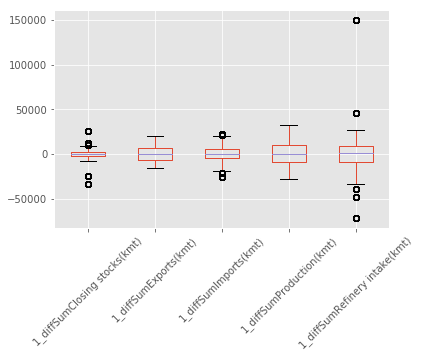

In [11]:
# Boxplot to look at univariate outliers
boxplots = X.loc[:, NUMERIC_VARIABLE[5:10]].boxplot(figsize=(14, 14))
plt.xticks(rotation=45)

### Create Variable

Le format du projet est une compétition où le meilleur score doit être obtenu. Dans ce cadre, la création de nouvelles features est primordiale. On créera un ensemble de nouvelles variables et on laissera le modèle décider des variables à conserver. Une partie de sélection de variables plus approfondies aurait probablement était nécessaire pour un projet tournant en production.

In [12]:
# List of columns to use to create new feature
COLUMNS_TO_TRANSFORM = list(X_full.columns[3:])

###### Variation in country vs variation in all countries

On compare les variations dans un pays (variables sans "Sum") aux variations dans tous les pays (variables avec "Sum" dans leurs noms).

In [13]:
COLUMNS_TO_TRANSFORM_WITHOUT_SUM = [x for x in COLUMNS_TO_TRANSFORM if (("Sum" not in x) and ("WTI" not in x))]

for var in COLUMNS_TO_TRANSFORM_WITHOUT_SUM:
    X_full.loc[:, var + "_diff_with_global"] =\
        X_full.loc[:, var] / X_full.loc[:, var.split("diff")[0] + "diffSum" + var.split("diff")[1]].abs()
    

###### Diff between export and import

Variation de la ballance commerciale

In [14]:
COLUMN_IMPORT =\
    [ x for x in COLUMNS_TO_TRANSFORM if ("_diffImports(kmt)" in x) ]
    
COLUMN_EXPORT =\
    [ x for x in COLUMNS_TO_TRANSFORM if ("_diffExports(kmt)" in x) ]
    
COLUMNS_IMPORT_EXPORT = [(a,b) for a,b in zip(COLUMN_IMPORT, COLUMN_EXPORT)]

for (a, b) in COLUMNS_IMPORT_EXPORT:
    X_full.loc[:, a + b] = X_full.loc[:, b] - X_full.loc[:, a]

###### Diff_import_export + closing stock

Variation de la balance commerciale + variation des stocks.

In [15]:
COLUMNS_CLOSING_STOCKS =\
    [ x for x in COLUMNS_TO_TRANSFORM if ("_diffClosing stocks(kmt)" in x) ]
    
COLUMNS_IMPORT_EXPORT_CLOSING_STOCK = [(a, b, c) for (a, b, c) 
                                       in zip(COLUMN_IMPORT, COLUMN_EXPORT, COLUMNS_CLOSING_STOCKS)]

for (a, b, c) in COLUMNS_IMPORT_EXPORT_CLOSING_STOCK:
    X_full.loc[:, a + b + c] = X_full.loc[:, c] + (X_full.loc[:, a] - X_full.loc[:, b])

###### If positiv

In [16]:
for var in COLUMNS_TO_TRANSFORM:
    X_full.loc[:, "binary_if_positive_" + var] =\
        X_full.loc[:, var].map(lambda x: fn.binary_if_positive(x))

###### If is 0

Certaines variables ont beaucoup de 0 dans leurs distribution (parfois plus de 50% de 0), on crée une nouvelle variable pour indiquer si la variable est à 0. Avec la varible "binary if positive", c'est une manière différente de catégoriser une variable selon (+, - ou 0).

A nouveau, la gestion des 0 pourrait probablement être une source d'amélioration importante pour le projet.

In [17]:
# Get columns with lot of 0
COLUMNS_WITH_0 =\
    [ x for x in COLUMNS_TO_TRANSFORM if ("_diffClosing stocks(kmt)" in x or "_diffExports(kmt)" in x
                                        or "_diffImports(kmt)" in x or "_diffRefinery intake(kmt" in x) ]

for var in COLUMNS_WITH_0:
    X_full.loc[:, "binary_if_0_" + var] =\
        X_full.loc[:, var].map(lambda x: fn.binary_if_0(x))
        
BINARY_0_COLUMNS =\
    pd.Series(X_full.columns ).loc[pd.Series(X_full.columns ).map(lambda x: "binary_if_0_" in x)]

###### Percent of 0 by columns, country and month

La même chose mais au niveau agrégée, avec le porucentage de 0 par columns, pays et mois de l'année.

In [18]:
for var in COLUMNS_WITH_0:
    if var == COLUMNS_WITH_0[0]:
        grouped_0_values =\
            X_full.loc[:, [var] + ["country", "month"]].groupby(["country", "month"])[var].\
                apply(lambda x: (x ==0).mean()).reset_index()
    else:
        temp_grouped_0_values =\
            X_full.loc[:, [var] + ["country", "month"]].groupby(["country", "month"])[var].\
                apply(lambda x: (x ==0).mean()).reset_index()
        grouped_0_values = grouped_0_values.merge(temp_grouped_0_values, how="left",
                                                 on=["country", "month"])
        
grouped_0_values.columns = list(grouped_0_values.columns[:2]) +\
                               ["percent_0_" + x for x in list(grouped_0_values.columns[2:])]
    
X_full = X_full.merge(grouped_0_values, how="left", on=["country", "month"])

###### Percent of 0 by country

In [19]:
for var in COLUMNS_WITH_0:
    if var == COLUMNS_WITH_0[0]:
        grouped_0_values =\
            X_full.loc[:, [var] + ["country"]].groupby(["country"])[var].\
                apply(lambda x: (x ==0).mean()).reset_index()
    else:
        temp_grouped_0_values =\
            X_full.loc[:, [var] + ["country"]].groupby(["country"])[var].\
                apply(lambda x: (x ==0).mean()).reset_index()
        grouped_0_values = grouped_0_values.merge(temp_grouped_0_values, how="left",
                                                 on=["country"])
        
grouped_0_values.columns = list(grouped_0_values.columns[:1]) +\
                               ["percent_0_country_" + x for x in list(grouped_0_values.columns[1:])]
    
X_full = X_full.merge(grouped_0_values, how="left", on=["country"])

###### Binary if Null

Avant d'imputer les valeurs manquantes dans la modélisation, on crée une variable indiquant si la valeur était manquante ou non dans la ligne.

In [20]:
for var in COLUMNS_TO_TRANSFORM:
    X_full.loc[:, "binary_if_null_" + var] =\
        X_full.loc[:, var].map(lambda x: fn.binary_if_null(x))

###### Aggregate by month and country

On crée un certains nombres de nouvelles valeurs agrégées par pays et par mois. A un fort impact sur la prédiction.

In [21]:
grouped_values =\
    X_full.loc[:, COLUMNS_TO_TRANSFORM + ["country", "month"]].replace(0, np.nan).groupby(["country", "month"]).\
        agg([np.nansum, np.nanmean, np.nanstd, np.min, 
             np.max, np.nanmedian, fn.percentile(75),
             fn.percentile(25), fn.percentile(10), fn.percentile(90),
             fn.percentile(5), fn.percentile(95)]).reset_index()
    
grouped_values.columns = [' '.join(col).strip() for col in grouped_values.columns.values]

X_full = X_full.merge(grouped_values, how="left", on=["country", "month"])

/home/thibault/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:842: RuntimeWarning: Mean of empty slice
  f = lambda x: func(x, *args, **kwargs)
/home/thibault/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/thibault/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


###### Aggregate by country

On crée un certains nombres de nouvelles valeurs agrégées par pays et par mois. N'apporte pas énormément d'informations lorsque les aggrégations par pays et mois de l'année sont présentes.

In [22]:
grouped_values =\
    X_full.loc[:, COLUMNS_TO_TRANSFORM + ["country"]].replace(0, np.nan).groupby(["country"]).\
        agg([np.nansum, np.nanmean, np.nanstd, np.min, 
             np.max, np.nanmedian, fn.percentile(75),
             fn.percentile(25), fn.percentile(10), fn.percentile(90),
             fn.percentile(5), fn.percentile(95)]).reset_index()
    
grouped_values.columns = [fn.new_name_if_not_id(' '.join(col).strip(), "_country_", "country") 
                          for col in grouped_values.columns.values]

X_full = X_full.merge(grouped_values, how="left", on="country")

/home/thibault/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:842: RuntimeWarning: Mean of empty slice
  f = lambda x: func(x, *args, **kwargs)
/home/thibault/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/thibault/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


###### Countries with no variation in import and export

Pays qui n'ont connu aucune variation de leurs importations, exportations et des deux.

In [23]:
countries_with_no_variation_in_import =\
    X_full.loc[:, ["1_diffImports(kmt)", "country"]].groupby("country")["1_diffImports(kmt)"].\
        apply(lambda x: (x == 0).mean()).reset_index()

In [24]:
countries_with_no_variation_in_export =\
    X_full.loc[:, ["1_diffExports(kmt)", "country"]].groupby("country")["1_diffExports(kmt)"].\
        apply(lambda x: (x == 0).mean()).reset_index()

In [25]:
countries_with_no_variation_in_import_export =\
    countries_with_no_variation_in_import.merge(countries_with_no_variation_in_export, how="left",
                                               on="country")
    
countries_with_no_variation_in_import_export.loc[:, "no_import_variation"] =\
    countries_with_no_variation_in_import.loc[:, "1_diffImports(kmt)"] == 1

countries_with_no_variation_in_import_export.loc[:, "no_export_variation"] =\
    countries_with_no_variation_in_export.loc[:, "1_diffExports(kmt)"] == 1
    
countries_with_no_variation_in_import_export.loc[:, "no_export_nor_import_variation"] =\
    countries_with_no_variation_in_import_export.no_import_variation &\
    countries_with_no_variation_in_import_export.no_export_variation
    
X_full =\
    X_full.merge(countries_with_no_variation_in_import_export, how="left",
                on="country")

###### Compute relative value by countries

Valeur relative (En comparaison à la somme pour le pays donné).

In [26]:
# Columns prefix to delete month in column name
COL_NAMES_WITHOUT_MONTH = set([x.split("_")[1] for x in COLUMNS_TO_TRANSFORM])

# By countries
relative_value = pd.DataFrame()
for var in list(COL_NAMES_WITHOUT_MONTH):
    relative_value_by_countries = pd.DataFrame()
    for localisation in set(X_full.country):
        all_months_columns = [str(j) + "_" + var for j in range(1, 13)]
        median_value = fn.data_frame_as_Series(X_full.loc[X_full.country == localisation, all_months_columns]).\
            dropna().sum()
        relative_value_by_countries_columns =\
            X_full.loc[X_full.country == localisation, all_months_columns] / median_value
        # replace inf
        relative_value_by_countries_columns =\
            relative_value_by_countries_columns.replace([np.inf, -np.inf], np.nan)
        relative_value_by_countries_columns.loc[:, "ID"] = X_full.loc[X_full.country == localisation, "ID"]
        if relative_value_by_countries.empty:
            relative_value_by_countries = relative_value_by_countries_columns
        else:
            relative_value_by_countries = pd.concat([relative_value_by_countries, 
                                                     relative_value_by_countries_columns],
                                                   axis=0)
    if relative_value.empty:
        relative_value = relative_value_by_countries
    else:
        relative_value = relative_value.merge(relative_value_by_countries, on="ID", how="left")


In [27]:
relative_value.columns = [fn.new_name_if_not_id(x, "relative_by_countries_") 
                          for x in list(relative_value.columns)]

In [28]:
X_full = X_full.merge(relative_value, how="left", on="ID")

###### Compute relative values by countries and month

Valeur relative (En comparaison à la somme pour le pays et le mois donnés).

In [29]:
# By countries
relative_value = pd.DataFrame()
for var in list(COL_NAMES_WITHOUT_MONTH):
    relative_value_by_countries = pd.DataFrame()
    for localisation in set(X_full.country):
        for month in set(X_full.month):
            all_months_columns = [str(j) + "_" + var for j in range(1, 13)]
            median_value = fn.data_frame_as_Series(X_full.loc[(X_full.country == localisation) &
                                                   (X_full.month == month), all_months_columns]).\
                dropna().sum()
            relative_value_by_countries_columns =\
                X_full.loc[(X_full.country == localisation) &
                           (X_full.month == month), all_months_columns] / median_value
            # replace inf
            relative_value_by_countries_columns =\
                relative_value_by_countries_columns.replace([np.inf, -np.inf], np.nan)
            relative_value_by_countries_columns.loc[:, "ID"] = X_full.loc[(X_full.country == localisation) &
                                                                          (X_full.month == month), "ID"]
            if relative_value_by_countries.empty:
                relative_value_by_countries = relative_value_by_countries_columns
            else:
                relative_value_by_countries = pd.concat([relative_value_by_countries, 
                                                         relative_value_by_countries_columns],
                                                       axis=0)
    if relative_value.empty:
        relative_value = relative_value_by_countries
    else:
        relative_value = relative_value.merge(relative_value_by_countries, on="ID", how="left")

In [30]:
relative_value.columns = [fn.new_name_if_not_id(x, "relative_by_countries_month_") 
                          for x in list(relative_value.columns)]

In [31]:
X_full = X_full.merge(relative_value, how="left", on="ID")

# Drop useless variable

Here, we drop variable without effect in modelisation, based on differents models iterations

In [32]:
common_useless_variable =\
    pd.read_csv(PATH_DATA + "common_useless_variable.csv", sep=";")

In [33]:
X_full = X_full.drop(list(common_useless_variable), axis=1)

# Split again between test and validation

###### Create dummies

On crée les variables dummies pour les variables catégorielles. La variable mois n'est pas modifié car semble donner de meilleur résultat non transformée. Pour une variable à n modalités, on ne garde que n-1 modalités pour éviter la multicolinéarité qui peut affecter certains modèles.

In [34]:
CATEGORICAL_VARIABLES = pd.Series(X_full.columns[X_full.apply(lambda x: (type(x.iloc[0]) != float), axis=0)])

# exclude month and ID
CATEGORICAL_VARIABLES = CATEGORICAL_VARIABLES.loc[CATEGORICAL_VARIABLES.map(lambda x: x not in ["ID", "month"])]

In [35]:
# We put only country as categorical because month seems to have higher impact as numeric
X_full = pd.get_dummies(X_full, columns=CATEGORICAL_VARIABLES, drop_first=True)

###### Split dataset

In [36]:
X = X_full.loc[X_full.ID.map(lambda x: x in list(X.ID)), :]
final_test = X_full.loc[X_full.ID.map(lambda x: x in list(final_test.ID)), :]

X_train, X_test, y_train, y_test =\
    train_test_split(X, Y, test_size=0.33, random_state=42)

# 3 - Model

On créera ici 3 modèle différents et l'on finira par construire un score final comme moyenne des 3 scores. Un modèle supplémentaire prenant en entrée les prédictions du modèle et les autres variables sera aussi testé. Sa capacité prédictive est bien moins bonne, il sera donc inclut trés légérement dans l'analyse pour apporte davantage de diversité.

A noter:
    - Le plus souvent on utilise des modèles avec des caractéristiques différentes pour les assembler. Ici, nous avons construit 3 modèles à base d'arbre et donc trés proches dans leur construction. Néanmoins, il s'agit des modèles qui donné les meilleurs résultats et les autres modèles testés n'ayant pas été satisfaisant, ils ont été exclus malgré la diversité qu'ils contenaient. Le seul modèle différent est la régréssion logistique à partir des autres modèles qui est un modèle linéaire, mais ses performances seuls n'étaient pas satisfaisante.
    
    - L'imputation des valeurs manquantes par la moyenne n'est pas une bonne pratique. On préférera le plus souvent un autre traitement (suppression des lignes ou colonnes avec trop de valeurs manquantes si celles-ci semblent aléatoires, éventuellement imputation par équations chainées multiples, ...)
    
    - Il aurait été plus propre de combiner les estimateurs dans une même pipeline, mais garder les modèles dans des éxécutions différentes permet d'observer les fonctionnements des modèles un à un.

In [37]:
N_ITER_SEARCH = 4
N_JOBS = 4

###### Random Forest

In [38]:
param_dist = {
              "rf__max_features": sp_randint(1, 100),
              "rf__min_samples_split": sp_randint(2, 30),
              "rf__min_samples_leaf": sp_randint(1, 20),
              # "rf__bootstrap": [False],
              # "pca__n_components": sp_randint(10, 300),
              # "pca__whiten": [True, False],
              # "select_from_model__threshold":sp_randint(0, 0.01),
              "rf__n_estimators": sp_randint(20, 500)
             }

pipe = Pipeline([# ("replace_0", Replace0()),
                 ("imputer", Imputer()),
                 # ("sd_scaler", StandardScaler()),
                 # ("pca", PCA(n_components=150, whiten=True)),
                 ("rf", RandomForestClassifier())
                 # ("rf", LogisticRegression(penalty="l1"))
                ])


random_search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   n_iter=N_ITER_SEARCH, n_jobs=N_JOBS, scoring="roc_auc")

random_search.fit(X_train.drop("ID", axis=1), y_train.Target)

print(random_search.best_score_)

rf_estimator = random_search.best_estimator_

print(random_search.best_params_)

0.827163491741
{'rf__max_features': 65, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 17, 'rf__n_estimators': 369}


###### Gradient boosting

In [39]:
param_dist = {
              "gb__max_features": sp_randint(1, 100),
              "gb__min_samples_split": sp_randint(2, 30),
              "gb__min_samples_leaf": sp_randint(1, 20),
              # "rf__bootstrap": [False],
              # "pca__n_components": sp_randint(10, 300),
              # "pca__whiten": [True, False],
              # "select_from_model__threshold":sp_randint(0, 0.01),
              "gb__n_estimators": sp_randint(20, 400)
             }

pipe = Pipeline([# ("replace_0", Replace0()),
                 ("imputer", Imputer()),
                 # ("sd_scaler", StandardScaler()),
                 # ("pca", PCA(n_components=150, whiten=True)),
                 ("gb", GradientBoostingClassifier())
                 # ("rf", LogisticRegression(penalty="l1"))
                ])


random_search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   n_iter=N_ITER_SEARCH, n_jobs=N_JOBS, scoring="roc_auc")

random_search.fit(X_train.drop("ID", axis=1), y_train.Target)

print(random_search.best_score_)

gb_estimator = random_search.best_estimator_

print(random_search.best_params_)

0.820689809311
{'gb__max_features': 71, 'gb__min_samples_leaf': 15, 'gb__min_samples_split': 13, 'gb__n_estimators': 126}


###### Extra tree

In [40]:
param_dist = {
              "et__max_features": sp_randint(1, 100),
              "et__min_samples_split": sp_randint(2, 30),
              "et__min_samples_leaf": sp_randint(1, 20),
              # "rf__bootstrap": [False],
              # "pca__n_components": sp_randint(10, 300),
              # "pca__whiten": [True, False],
              # "select_from_model__threshold":sp_randint(0, 0.01),
              "et__n_estimators": sp_randint(20, 400)
             }

pipe = Pipeline([# ("replace_0", Replace0()),
                 ("imputer", Imputer()),
                 # ("sd_scaler", StandardScaler()),
                 # ("pca", PCA(n_components=150, whiten=True)),
                 ("et", ExtraTreesClassifier())
                 # ("rf", LogisticRegression(penalty="l1"))
                ])


random_search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   n_iter=N_ITER_SEARCH, n_jobs=N_JOBS, scoring="roc_auc")

random_search.fit(X_train.drop("ID", axis=1), y_train.Target)

print(random_search.best_score_)

et_estimator = random_search.best_estimator_

print(random_search.best_params_)

0.826754846956
{'et__max_features': 81, 'et__min_samples_leaf': 9, 'et__min_samples_split': 9, 'et__n_estimators': 246}


###### New model with feature from previous model

In [41]:
N_ITER_SEARCH_lr = 1

In [42]:
rf_proba_predictions = rf_estimator.predict_proba(X_full.drop(["ID"], axis=1))[:, 1]
gb_proba_predictions = gb_estimator.predict_proba(X_full.drop(["ID"], axis=1))[:, 1]
et_proba_predictions = et_estimator.predict_proba(X_full.drop(["ID"], axis=1))[:, 1]


X_full.loc[:, "prediction_rf"] = rf_proba_predictions
X_full.loc[:, "prediction_gb"] = gb_proba_predictions
X_full.loc[:, "prediction_et"] = gb_proba_predictions

X = X_full.loc[X_full.ID.map(lambda x: x in list(X.ID)), :]
final_test = X_full.loc[X_full.ID.map(lambda x: x in list(final_test.ID)), :]

X_train, X_test, y_train, y_test =\
    train_test_split(X, Y, test_size=0.33, random_state=42)

In [43]:
param_dist = {
              # "lr__max_features": sp_randint(1, 100),
              # "lr__min_samples_split": sp_randint(2, 30),
              # "lr__min_samples_leaf": sp_randint(1, 20),
              # "rf__bootstrap": [False],
              # "pca__n_components": sp_randint(10, 300),
              # "pca__whiten": [True, False],
              # "select_from_model__threshold":sp_randint(0, 0.01),
              # "lr__n_estimators": sp_randint(20, 400)
             }

pipe = Pipeline([# ("replace_0", Replace0()),
                 ("imputer", Imputer()),
                 ("sd_scaler", StandardScaler()),
                 # ("pca", PCA(n_components=150, whiten=True)),
                 ("lr", LogisticRegression("l1"))
                 # ("rf", LogisticRegression(penalty="l1"))
                ])

random_search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   n_iter=N_ITER_SEARCH_lr, n_jobs=N_JOBS, scoring="roc_auc")

random_search.fit(X_train.drop("ID", axis=1), y_train.Target)

print(random_search.best_score_)

lr_estimator = random_search.best_estimator_

print(random_search.best_params_)

0.967272475765
{}


# 4 - EVALUATION

### A) Random Forest

###### Train set

In [44]:
y_train_predit = rf_estimator.predict_proba(X_train.drop(["ID", "prediction_rf", 
                                                          "prediction_gb", "prediction_et"], axis=1))[:, 1]

result_comparison = pd.DataFrame(y_train).merge(pd.DataFrame(y_train_predit), left_index=True, right_index=True)
result_comparison.sample(10)

roc_auc_score(y_train.Target, y_train_predit)

0.95583525423565008

###### Test set

In [45]:
y_test_predit = rf_estimator.predict_proba(X_test.drop(["ID", "prediction_rf", 
                                                        "prediction_gb", "prediction_et"], axis=1))[:, 1]

result_comparison = pd.DataFrame(y_test).merge(pd.DataFrame(y_test_predit), left_index=True, right_index=True)
result_comparison.sample(10)

roc_auc_score(y_test.Target, y_test_predit)

0.8332972681673092

### B) Gradient boosting

###### Train set

In [46]:
y_train_predit = gb_estimator.predict_proba(X_train.drop(["ID", "prediction_rf", 
                                                        "prediction_gb", "prediction_et"], axis=1))[:, 1]

result_comparison = pd.DataFrame(y_train).merge(pd.DataFrame(y_train_predit), left_index=True, right_index=True)
result_comparison.sample(10)

roc_auc_score(y_train.Target, y_train_predit)

0.89522650740493748

###### Test set

In [47]:
y_test_predit = gb_estimator.predict_proba(X_test.drop(["ID", "prediction_rf", 
                                                        "prediction_gb", "prediction_et"], axis=1))[:, 1]

result_comparison = pd.DataFrame(y_test).merge(pd.DataFrame(y_test_predit), left_index=True, right_index=True)
result_comparison.sample(10)

roc_auc_score(y_test.Target, y_test_predit)

0.83171993533142652

### C) Extra tree

###### Train set

In [48]:
y_train_predit = et_estimator.predict_proba(X_train.drop(["ID", "prediction_rf", 
                                                        "prediction_gb", "prediction_et"], axis=1))[:, 1]

result_comparison = pd.DataFrame(y_train).merge(pd.DataFrame(y_train_predit), left_index=True, right_index=True)
result_comparison.sample(10)

roc_auc_score(y_train.Target, y_train_predit)

0.9482059094526113

###### Test set

In [49]:
y_test_predit = et_estimator.predict_proba(X_test.drop(["ID", "prediction_rf", 
                                                        "prediction_gb", "prediction_et"], axis=1))[:, 1]

result_comparison = pd.DataFrame(y_test).merge(pd.DataFrame(y_test_predit), left_index=True, right_index=True)
result_comparison.sample(10)

roc_auc_score(y_test.Target, y_test_predit)

0.83204079094639971

### D) Logistic regression

###### Test set

In [50]:
y_test_predit = lr_estimator.predict_proba(X_test.drop(["ID"], axis=1))[:, 1]

result_comparison = pd.DataFrame(y_test).merge(pd.DataFrame(y_test_predit), left_index=True, right_index=True)
result_comparison.sample(10)

roc_auc_score(y_test.Target, y_test_predit)

/home/thibault/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


0.78755461592670895

### E) Combining estimator

In [51]:
y_test_predit = 0.33 * rf_estimator.predict_proba(X_test.drop(["ID", "prediction_rf", 
                                                               "prediction_gb", "prediction_et"], axis=1))[:, 1] +\
                0.33 * gb_estimator.predict_proba(X_test.drop(["ID", "prediction_rf", 
                                                               "prediction_gb", "prediction_et"], axis=1))[:, 1] +\
                0.34 * et_estimator.predict_proba(X_test.drop(["ID", "prediction_rf", 
                                                               "prediction_gb", "prediction_et"], axis=1))[:, 1] +\
                0.00 * lr_estimator.predict_proba(X_test.drop("ID", axis=1))[:, 1]

result_comparison = pd.DataFrame(y_test).merge(pd.DataFrame(y_test_predit), left_index=True, right_index=True)
result_comparison.sample(10)

roc_auc_score(y_test.Target, y_test_predit)

/home/thibault/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


0.83550719230609793

# Variable importance

On regarde l'importance des variables pour rechercher des pistes d'amélioration et pour avoir une idée du comportement du modèle. On voit notamment que les sommes au niveau globale ont un fort impact, il y a probablement un fort potentiel d'amélioration en chechant à créer des variables supplémentaires à partir de ces variables.

Si les dates étaients connues plus précisement, la recherche de variables en open data auraient probablement apporté beaucoup au modèle.

Beaucoup de variables avec de faibles importances car beaucoup de features en input.

###### Random Forest

(array([  3.13200000e+03,   4.05000000e+02,   4.40000000e+01,
          2.20000000e+01,   2.50000000e+01,   1.40000000e+01,
          1.40000000e+01,   5.00000000e+00,   2.00000000e+00,
          2.00000000e+00]),
 array([ 0.        ,  0.00051581,  0.00103162,  0.00154743,  0.00206324,
         0.00257905,  0.00309486,  0.00361067,  0.00412648,  0.00464229,
         0.0051581 ]),
 <a list of 10 Patch objects>)

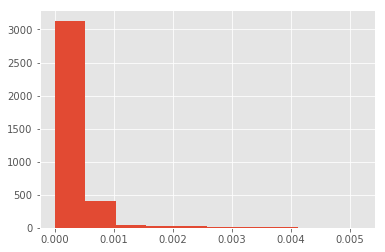

In [61]:
plt.hist(rf_estimator.named_steps["rf"].feature_importances_)

In [62]:
variable_importance_rf =\
    pd.concat([pd.DataFrame(X_train.columns),
               pd.DataFrame(rf_estimator.named_steps["rf"].feature_importances_)], axis=1)
variable_importance_rf.columns =["variable", "importance"]
    
variable_importance_rf = variable_importance_rf.sort_values(by="importance", ascending=False)
variable_importance_rf.head(15)

,variable,importance
282,percent_0_country_11_diffClosing stocks(kmt),0.005158
401,1_diffSumRefinery intake(kmt) amax,0.005041
372,1_diffSumExports(kmt) percentile_95,0.004403
3630,binary_if_0_7_diffClosing stocks(kmt)_1,0.004243
258,percent_0_country_5_diffClosing stocks(kmt),0.004090
363,1_diffSumExports(kmt) nanstd,0.004071
274,percent_0_country_9_diffClosing stocks(kmt),0.003896
226,percent_0_9_diffClosing stocks(kmt),0.003886
1686,12_diffSumExports(kmt) nanmedian,0.003692
254,percent_0_country_4_diffClosing stocks(kmt),0.003608


In [63]:
# Less important variable
useless_variable_rf = fn.get_useless_variable(rf_estimator.named_steps["rf"], X_train)
useless_variable_rf.head()

481       2_diffSumExports(kmt) nansum
484         2_diffSumExports(kmt) amin
496         2_diffSumImports(kmt) amin
606    3_diffSumExports(kmt) nanmedian
817                   5_diffWTI nansum
Name: variable, dtype: object

###### Gradient boosting

In [64]:
# Less important variable
useless_variable_gb = fn.get_useless_variable(gb_estimator.named_steps["gb"], X_train)
useless_variable_gb.head()


0                              ID
1                           month
5      1_diffRefinery intake(kmt)
7    1_diffSumClosing stocks(kmt)
8           1_diffSumExports(kmt)
Name: variable, dtype: object

###### Extra tree

In [65]:
# Less important variable
useless_variable_et = fn.get_useless_variable(et_estimator.named_steps["et"], X_train)
useless_variable_et.head()

1776    _country_1_diffRefinery intake(kmt) percentile_95
1777                            _country_1_diffWTI nansum
1778                           _country_1_diffWTI nanmean
1779                            _country_1_diffWTI nanstd
1780                              _country_1_diffWTI amin
Name: variable, dtype: object

###### Common useless variable

In [66]:
common_useless_variable =\
    pd.Series(list((set(useless_variable_gb) - set(useless_variable_rf)) - set(useless_variable_et)))

In [67]:
# Drop useless variable_to_disk
# common_useless_variable.to_csv(PATH_DATA + "common_useless_variable.csv", index=False, sep=";")

# 5 - Prediction

On construit les prédictions finales comme une combinaisonsdes performances estimés par les modèles précédants.

Le résultat de la régréssion logistique ne sera finalement pas inclus.

In [68]:
id_final_test = final_test.ID

X_final_test = final_test.drop("ID", axis=1)

In [69]:
predictions = 0.33 * rf_estimator.predict_proba(X_final_test.drop(["prediction_rf", 
                                                                   "prediction_gb", "prediction_et"], axis=1))[:, 1] +\
              0.33 * gb_estimator.predict_proba(X_final_test.drop(["prediction_rf", 
                                                                   "prediction_gb", "prediction_et"], axis=1))[:, 1] +\
              0.34 * et_estimator.predict_proba(X_final_test.drop(["prediction_rf", 
                                                                   "prediction_gb", "prediction_et"], axis=1))[:, 1] +\
              0.00 * lr_estimator.predict_proba(X_final_test)[:, 1]
    

/home/thibault/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [70]:
result = pd.DataFrame(predictions).merge(pd.DataFrame(id_final_test).reset_index(drop=True), 
                                         left_index=True, right_index=True)
result.columns = ["Target", "ID"]
result = result.loc[:, ["ID", "Target"]]
result.head()

,ID,Target
0,ID10160,0.384645
1,ID10161,0.015771
2,ID10162,0.571102
3,ID10163,0.801886
4,ID10164,0.334052


In [71]:
result.to_csv(PATH_RESULT + "result.csv", index=False, sep=";", quoting=csv.QUOTE_NONNUMERIC)